# Rock and States

A tutorial on `Rock` and `States` components and their  transformations.

### Content
* [Basic properties](#Basic-properties)
* [Visualization](#Visualization)
* [Transformations](#Transformations)
    * [Generic methods](#Generic-methods)
    * [Upscaling](#Upscaling)

## Basic properties

In essence, `Rock` and `States` components are very similar, the only difference is that 
`Rock` component contains time-independent model properties in 3D arrays, for example:
* `PORO` - porosity;
* `PERMX` - x-permeability;
* `PERMZ` - y-permeability;
* `PERMY` - z-permeability.

while `States` component contains time-dependent model properties, in 4D arrays (i.e., three spatial and a single time axis), for example:
* `PRESSURE` - pore volume pressure;
* `SOIL` - oil saturation;
* `SWAT` - water saturation;
* `SGAS` - gas saturation;
* `RS` - dissolved gas content.

Required imports:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield import Field

Load a model (this is the HDF5 model created in the first [tutorial](./01.Basics.ipynb)):

In [2]:
model = Field(path='egg.hdf5').load()

INFO:Field:===== Field summary =====
INFO:Field:AQUIFERS attributes: 
INFO:Field:FAULTS attributes: 
INFO:Field:GRID attributes: MAPAXES, TOPS, ACTNUM, COORD, DIMENS, DX, DY, DZ, ZCORN
INFO:Field:ROCK attributes: NTG, PERMX, PERMY, PERMZ, PORO
INFO:Field:STATES attributes: PRESSURE, SOIL, SWAT
INFO:Field:TABLES attributes: DENSITY, PVCDO, PVTW, ROCK, SWOF
INFO:Field:WELLS attributes: COMPDAT, BLOCKS, WELLTRACK, WELSPECS, RESULTS, WCONPROD, BLOCKS_INFO, WCONINJE
INFO:Field:=========================


List of rock attributes:

In [3]:
model.rock.attributes

('NTG', 'PERMX', 'PERMY', 'PERMZ', 'PORO')

Note that attributes are case-insensitive:

In [4]:
(model.rock.poro == model.rock.PORO).all()

True

Attrubutes are in a spatial shape by default (3D or 4D):

In [5]:
model.rock.permx.shape

(60, 60, 7)

Note that for `States`, the behavior of the `getitem` method is a bit more complicated. Passing a string with the attribute name, you get a 4D array of values of this attribute:

In [6]:
model.states['SOIL'].shape

(121, 60, 60, 7)

If you pass an integer, a list of integers, or a boolean mask, they will be interpreted as time steps, and you will get a new instance of `States` with only those time steps:

In [7]:
model.states[[10, 11, 12]].soil.shape

(3, 60, 60, 7)

The same thing happens when you pass a slice:

In [8]:
model.states[:10].soil.shape

(10, 60, 60, 7)

## Visualization

Array attributes can be visualized in 3D using a separate interactive window:
```python
model.show(attr='PERMX')
```
or, alternalively, one can use a simplified inline 2D visualization of slices:

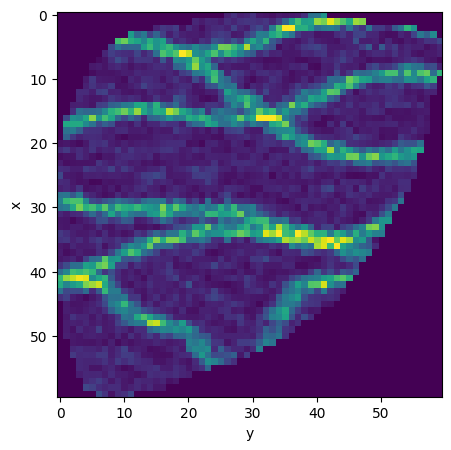

In [9]:
model.rock.show_slice(attr='permx', z=2, figsize=(7, 5), aspect='equal')

If slice is not specified, the interactive 2D mode with slice widgets will be activated. Note that x, y and z list the axis order, not the spatial coordinates:

In [10]:
model.rock.show_slice(attr='permx', figsize=(12, 5))

<p>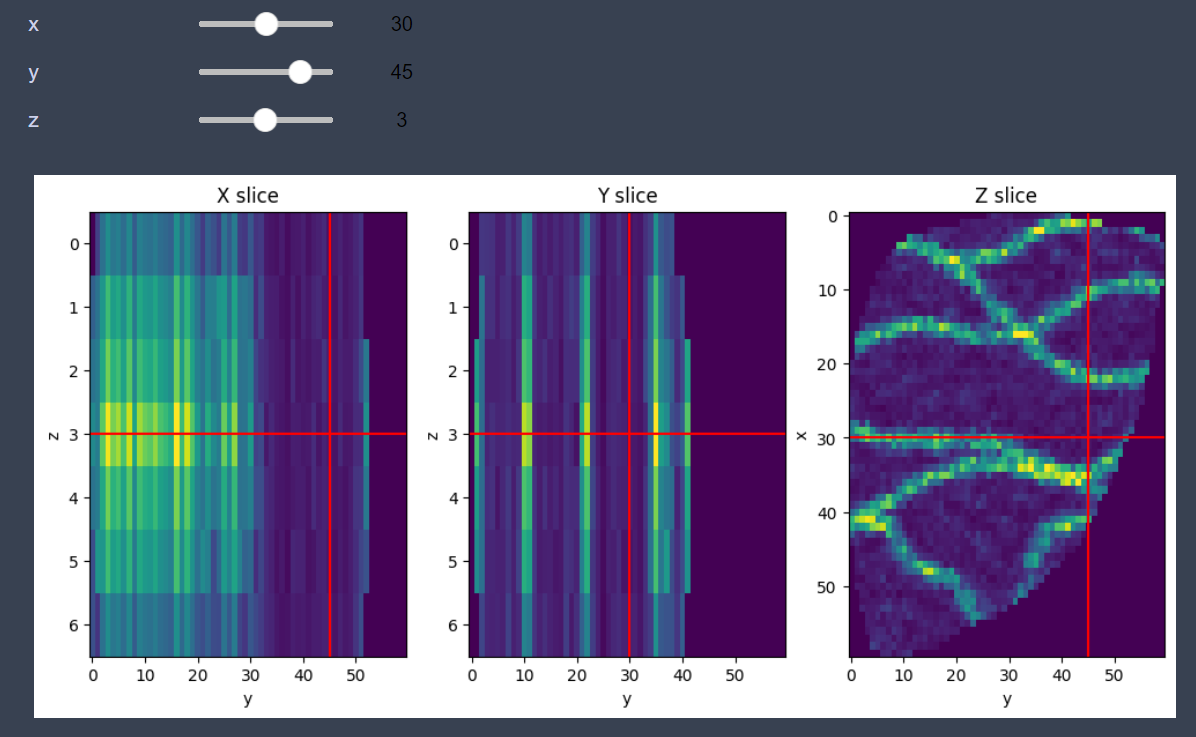 

Also for quick estimation of properties one can plot a histogram:

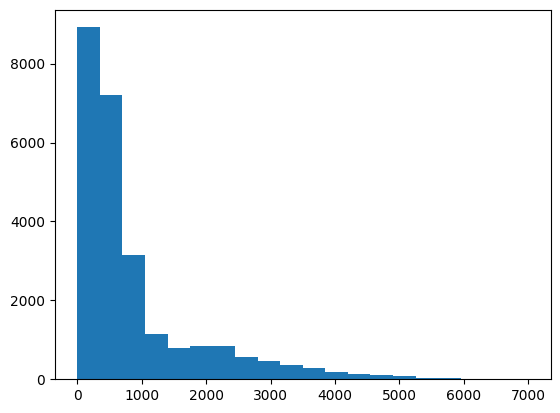

In [11]:
model.rock.show_histogram('permx', bins=20)

## Transformations

Components contain a number of built-in methods. In general, these methods have a similar signature: one have to specify the attribute or list of attributes to which the method will be applied, decide whether to keep the result inplace or output it, and specify additional keywords for a particular method.

### Generic methods

Rock contain a number of generic methods inherited from `skimage` for ndarrays transformation. 
For example, arrays can be 
* resized

In [12]:
poro = model.rock.resize(attr='poro', output_shape=(10, 12, 14), inplace=False)
poro.shape

(10, 12, 14)

* flipped

In [13]:
poro = model.rock.flip(attr='poro', axis=0, inplace=False)

* rotated

In [14]:
poro = model.rock.rot90(attr='poro', k=1, inplace=False)
print('Original shape:', model.rock.poro.shape)
print('Rotated shape:', poro.shape)

Original shape: (60, 60, 7)
Rotated shape: (60, 60, 7)


* randomized with some noise:

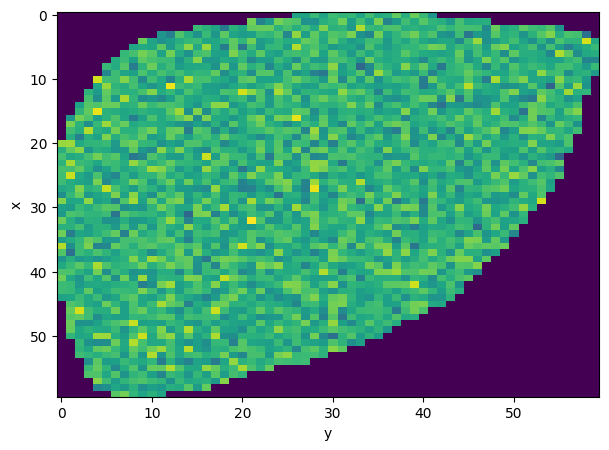

In [15]:
model.rock.random_noise(attr='poro', var=0.001, inplace=True)
model.rock.show_slice(attr='poro', z=2, figsize=(7, 5))

Also many methods from [`scipy.ndarray`](https://docs.scipy.org/doc/scipy/reference/ndimage.html#) module are included. E.g.,  one can apply median filter:

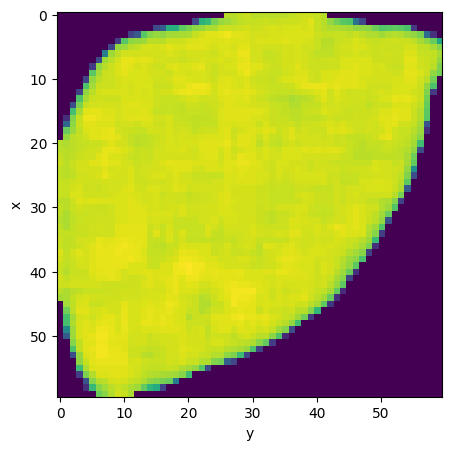

In [16]:
model.rock.median_filter(attr='poro', size=5, inplace=True)
model.rock.show_slice(attr='poro', z=2, figsize=(7, 5), aspect='equal')

Custom functions that accept data as its first argument can also be applied:

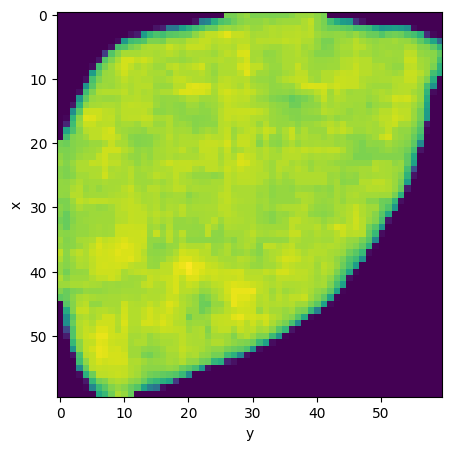

In [17]:
model.rock.apply(lambda x: x**2, attr='poro', inplace=True)
model.rock.show_slice(attr='poro', z=2, figsize=(7, 5), aspect='equal')

### Upscaling

Unscaling of rock properties is a bit tricker than a generic arrays rescaling. For porosity upscaling a volume averaging a required: 

In [18]:
up_poro = model.rock.upscale(attr='poro', factors=2)
up_poro.shape

(30, 30, 3)

Upscaling the permeability, we use porosity as a weighting factor:

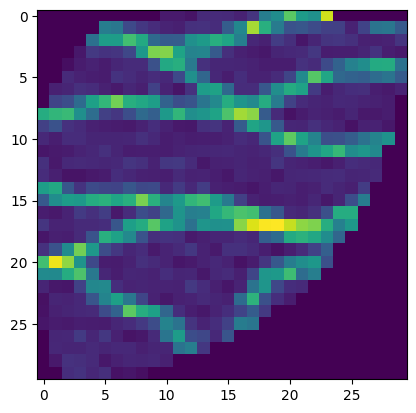

In [19]:
up_permx = model.rock.upscale(attr='permx', factors=2, weights=model.rock.poro)
plt.imshow(up_permx[..., 1], aspect='equal')
plt.show()

Done!